In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer as Stemmer
from nltk import WordNetLemmatizer as Lemmatizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN
from sklearn.model_selection import train_test_split as split_data
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder as le
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
data = pd.read_csv('Sentiment.csv')

In [3]:
# get number of unique values in "sentiment"
print(data.groupby('sentiment').nunique())

             id  candidate  candidate_confidence  relevant_yn  \
sentiment                                                       
Negative   8493         11                   676            1   
Neutral    3142         11                   494            1   
Positive   2236         11                   338            1   

           relevant_yn_confidence  sentiment_confidence  subject_matter  \
sentiment                                                                 
Negative                      358                   895              12   
Neutral                       313                   686              12   
Positive                      181                   562              11   

           subject_matter_confidence  candidate_gold  name  relevant_yn_gold  \
sentiment                                                                      
Negative                        1111               6  6334                 1   
Neutral                          704               3  2754

In [4]:
# keep only the neccessary columns (text and sentiment)
data = data[['text','sentiment']]
# check data after removing other columns
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


### Update list of Stop Words based on previous word cloud plots

In [5]:
stop_words.extend(['gopdebate', 'gopdebates', 'debate', 'realdonaldtrump', 'rwsurfergirl'])

In [6]:
# check data before pre processing
print(data['text'][0])
print(data['text'][1])
print(data['text'][2])

RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.


In [7]:
# using regular expression to convert all strings to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
# using regular expression to preprocess the text by removing everything that is not [a-zA-z0-9\s]
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

In [8]:
# Iterate over DataFrame rows as (index, Series) pairs.
for idx, row in data.iterrows():
    # remove 'rt'(retweet) in the start of the text
    row[0] = row[0].replace('rt', '')

In [9]:
# print some data to check the process
print(data['text'][0])
print(data['text'][1])
print(data['text'][2])

 nancyleegrahn how did everyone feel about the climate change question last night exactly gopdebate
 scottwalker didnt catch the full gopdebate last night here are some of scotts best lines in 90 seconds walker16 httptcozsff
 tjmshow no mention of tamir rice and the gopdebate was held in cleveland wow


In [10]:
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [11]:
# print some data to check the process
print(data['text'][0])
print(data['text'][1])
print(data['text'][2])

nancyleegrahn everyone feel climate change question last night exactly
scottwalker didnt catch full last night scotts best lines 90 seconds walker16 httptcozsff
tjmshow mention tamir rice held cleveland wow


### Naive Bayes and Logistic Rgeression Best Models from Previous Assignment Predictions:

In [12]:
def ext_NounVerbs(text):
    tokens = word_tokenize(text)
    return ' '.join([word for word, pos in pos_tag(tokens) if pos.startswith(('N', 'V'))])

In [13]:
X = data['text']
y = data['sentiment']
# label encode the labels, define label encoder
le_enc = le()
# fit transform on the labels
y = le_enc.fit_transform(y)

In [14]:
X1 = X.apply(ext_NounVerbs)
X1_train, X1_test, y1_train, y1_test = split_data(X1, y, test_size = 0.3, random_state = 42)

In [15]:
print(X.head())
print('='*30)
print(X1.head())

0    nancyleegrahn everyone feel climate change que...
1    scottwalker didnt catch full last night scotts...
2        tjmshow mention tamir rice held cleveland wow
3    robgeorge carly fiorina trending hours men jus...
4    danscavino w delivered highest ratings history...
Name: text, dtype: object
0               everyone climate change question night
1    scottwalker didnt catch night scotts lines sec...
2        tjmshow mention tamir rice held cleveland wow
3    robgeorge fiorina trending hours men justcompl...
4    danscavino w delivered ratings history debates...
Name: text, dtype: object


In [16]:
vectorizer = CountVectorizer(ngram_range=(1, 3))
X1_train_cv = vectorizer.fit_transform(X1_train)
X1_test_cv = vectorizer.transform(X1_test)

In [17]:
nb = MultinomialNB()
nb.fit(X1_train_cv, y1_train)

lr = LogisticRegression(max_iter=150)
lr.fit(X1_train_cv, y1_train)

LogisticRegression(max_iter=150)

In [18]:
accs = []

In [19]:
y1_pred = nb.predict(X1_test_cv)
print('Naive Bayes Accuracy: ' + str(accuracy_score(y1_test, y1_pred)*100)+'%')
accs.append(accuracy_score(y1_test, y1_pred))

y2_pred = lr.predict(X1_test_cv)
print('Logistic Regression Accuracy: '+ str(accuracy_score(y1_test, y2_pred)*100)+'%')
accs.append(accuracy_score(y1_test, y2_pred))

Naive Bayes Accuracy: 66.9629985583854%
Logistic Regression Accuracy: 68.11629024507448%


### Pre Processing for current assignment

In [20]:
# Word tokenize texts
data['text'] = [word_tokenize(text) for text in data['text']]

In [21]:
# print some data to check the process
print(data['text'][0])
print(data['text'][1])
print(data['text'][2])

['nancyleegrahn', 'everyone', 'feel', 'climate', 'change', 'question', 'last', 'night', 'exactly']
['scottwalker', 'didnt', 'catch', 'full', 'last', 'night', 'scotts', 'best', 'lines', '90', 'seconds', 'walker16', 'httptcozsff']
['tjmshow', 'mention', 'tamir', 'rice', 'held', 'cleveland', 'wow']


In [22]:
# Stemming tokenized words
st = Stemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data['text'] = data['text'].apply(lambda x: stemming_on_text(x))

In [23]:
# print some data to check the process
print(data['text'][0])
print(data['text'][1])
print(data['text'][2])

['nancyleegrahn', 'everyone', 'feel', 'climate', 'change', 'question', 'last', 'night', 'exactly']
['scottwalker', 'didnt', 'catch', 'full', 'last', 'night', 'scotts', 'best', 'lines', '90', 'seconds', 'walker16', 'httptcozsff']
['tjmshow', 'mention', 'tamir', 'rice', 'held', 'cleveland', 'wow']


In [24]:
#get POS of words
def get_pos(data, word):
    for word_, tags in nltk.pos_tag(data):
        if word_ == word:
            if tags.startswith('J'):
                return wordnet.ADJ
            elif tags.startswith('V'):
                return wordnet.VERB
            elif tags.startswith('N'):
                return wordnet.NOUN
            elif tags.startswith('R'):
                return wordnet.ADV
            else:
                return None

def pos_tagging(data):
    text = [nltk.pos_tag(data)]
    return data
    
tags = data['text'].apply(lambda x: pos_tagging(x))

# Lemmatizing
lm = Lemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word, pos = "n") for word in data]
    return data
data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [25]:
# print some data to check the process
print(data['text'][0])
print(data['text'][1])
print(data['text'][2])

['nancyleegrahn', 'everyone', 'feel', 'climate', 'change', 'question', 'last', 'night', 'exactly']
['scottwalker', 'didnt', 'catch', 'full', 'last', 'night', 'scotts', 'best', 'lines', '90', 'seconds', 'walker16', 'httptcozsff']
['tjmshow', 'mention', 'tamir', 'rice', 'held', 'cleveland', 'wow']


Text(0.5, 1.0, 'Word Cloud of Positive Texts')

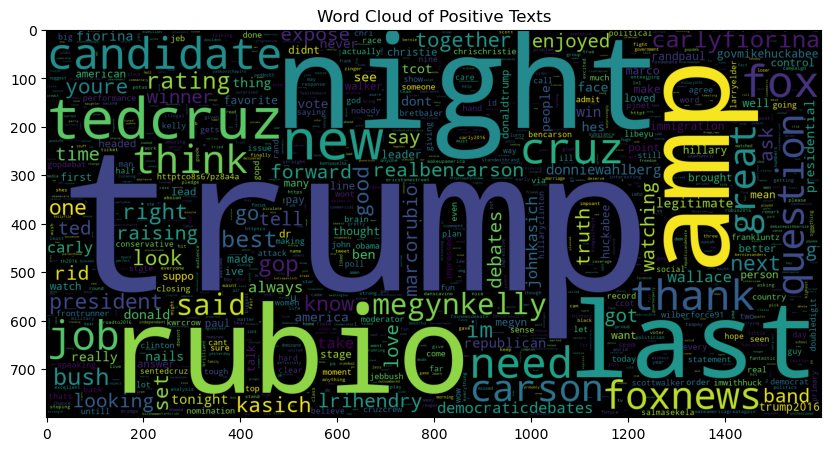

In [26]:
data_pos = data.loc[data['sentiment'] == "Positive"]
data_pos = data_pos['text'].explode().tolist()
data_pos = [x for x in data_pos if str(x) != 'nan']

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)
plt.title("Word Cloud of Positive Texts")

Text(0.5, 1.0, 'Word Cloud of Negative Texts')

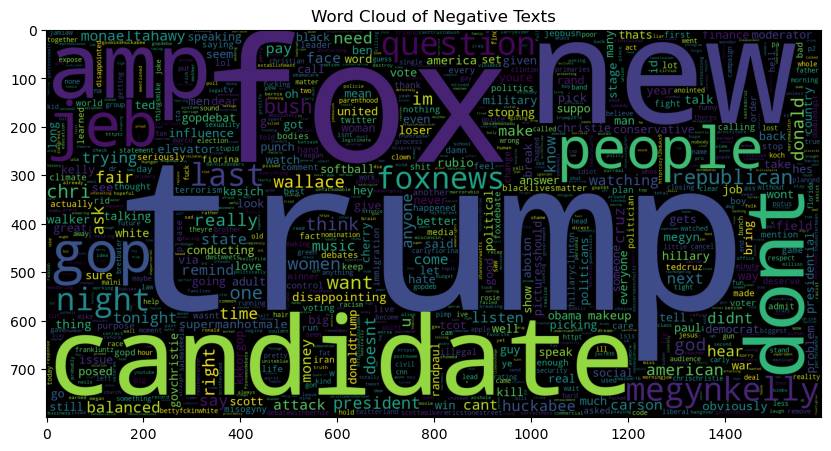

In [27]:
data_neg = data.loc[data['sentiment'] == "Negative"]
data_neg = data_neg['text'].explode().tolist()
data_neg = [x for x in data_neg if str(x) != 'nan']

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.title("Word Cloud of Negative Texts")

Text(0.5, 1.0, 'Word Cloud of Neutral Texts')

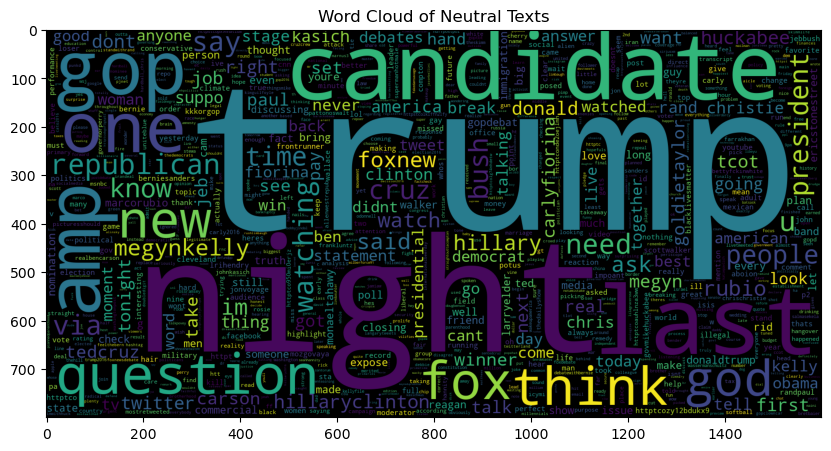

In [28]:
data_net = data.loc[data['sentiment'] == "Neutral"]
data_net = data_net['text'].explode().tolist()
data_net = [x for x in data_net if str(x) != 'nan']

plt.figure(figsize = (10, 10))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(data_net))
plt.imshow(wc)
plt.title("Word Cloud of Neutral Texts")

In [29]:
# define max features
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)

In [30]:
# Transforms each text in texts to a sequence of integers.
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.
X = tokenizer.texts_to_sequences(data['text'].values)

In [31]:
# Check the sequence of the text, Do we need to Pad ??
for i in range(4):
    print(X[i])
    print('len=', len(X[i]))

[238, 344, 309, 259, 33, 5, 11, 905]
len= 8
[248, 49, 1807, 487, 5, 11, 90, 1280, 1439, 1214, 718]
len= 11
[386, 1656, 574, 407]
len= 4
[182, 145, 611, 94, 123, 657]
len= 6


In [32]:
# pad sequences to same length using pad_sequences method
X = pad_sequences(X)
print('X.shape = ', X.shape)

X.shape =  (13871, 23)


In [33]:
# Check the sequence after padding
for i in range(4):
    print(X[i])
    print('len=', len(X[i]))
    
max_len = len(X[i])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 238 344 309
 259  33   5  11 905]
len= 23
[   0    0    0    0    0    0    0    0    0    0    0    0  248   49
 1807  487    5   11   90 1280 1439 1214  718]
len= 23
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  386 1656  574  407]
len= 23
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 182
 145 611  94 123 657]
len= 23


## Define Methods for all Models

In [34]:
''' RNN model with few parameters '''
def RNNmodel1():
    # define embedding dimension
    embed_dim = 128
    # define RNN out
    # ============== FEWER PARAMETERS ================
    rnn_out = 32
    max_features = 2000
    
    # Define sequential model
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    
    # Add SimpleRNN layer with given number of units
    model.add(SimpleRNN(rnn_out))
    
    # Add output layer with softmax for 3 sentiments
    model.add(Dense(3, activation='softmax'))
    
    # Compile model with binary cross-entropy loss and Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    # Return the model
    return model

''' RNN model with more parameters '''
def RNNmodel2():
    # define embedding dimension
    embed_dim = 128
    # define RNN out
    # ============== MORE PARAMETERS ================
    rnn_out = 128
    max_features = 2000
    
    # Define sequential model
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    
    # Add SimpleRNN layer with given number of units
    model.add(SimpleRNN(rnn_out))
    
    # Add output layer with softmax for 3 sentiments
    model.add(Dense(3, activation='softmax'))
    
    # Compile model with binary cross-entropy loss and Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    # Return the model
    return model

''' RNN model with overfitiing strategies '''
def RNNmodel3():
    # define embedding dimension
    embed_dim = 128
    # define RNN out
    # ============== OVERFITTING STRAGTEGIES APPLIED ================
    rnn_out = 128
    max_features = 2000
    
    # Define sequential model
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    
    # Add SimpleRNN layer with given number of units
    model.add(SimpleRNN(rnn_out, dropout=0.2, recurrent_dropout=0.2))
    
    # Add output layer with softmax for 3 sentiments
    model.add(Dense(3, activation='softmax'))
    
    # Compile model with binary cross-entropy loss and Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    # Return the model
    return model

''' LSTM model with few parameters '''
def LSTMmodel1():
    # define embedding dimension
    embed_dim = 128
    # define LSTM out
    # ============== FEWER PARAMETERS ================
    lstm_out = 32
    max_features = 2000
    
    # define sequential model
    model = Sequential()
    # add embedding layer
    model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
    
    # add LSTM layer
    model.add(LSTM(lstm_out))
    
    # output layer for 3 classes. Softmax as we have more than 2 classes.
    model.add(Dense(3,activation='softmax'))
    
    # compile model using defined metrics
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    # get model summary
    model.summary()
    
    # return the model
    return model

''' LSTM model with more parameters '''
def LSTMmodel2():
    # define embedding dimension
    embed_dim = 128
    # define LSTM out
    # ============== MORE PARAMETERS ================
    lstm_out = 128
    max_features = 2000
    
    # define sequential model
    model = Sequential()
    # add embedding layer
    model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
    
    # add LSTM layer
    model.add(LSTM(lstm_out))
    
    # output layer for 3 classes. Softmax as we have more than 2 classes.
    model.add(Dense(3,activation='softmax'))
    
    # compile model using defined metrics
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    # get model summary
    model.summary()
    
    # return the model
    return model

''' LSTM model with overfitiing strategies '''
def LSTMmodel3():
    # define embedding dimension
    embed_dim = 128
    # define LSTM out
    # ============== OVERFITTING STRAGTEGIES APPLIED ================
    lstm_out = 128
    max_features = 2000
    
    # define sequential model
    model = Sequential()
    # add embedding layer
    model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
    
    # add LSTM layer
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    
    # output layer for 3 classes. Softmax as we have more than 2 classes.
    model.add(Dense(3,activation='softmax'))
    
    # compile model using defined metrics
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    # get model summary
    model.summary()
    
    # return the model
    return model

In [35]:
y_onehot = to_categorical(y)

# split the data for training and validation
X_train, X_test, y_train, y_test = split_data(X, y_onehot, test_size = 0.3, random_state = 42)

# batch size for training
batch_size = 32

In [36]:
# define the models using the methods
rnn1 = RNNmodel1()
rnn2 = RNNmodel3()
rnn3 = RNNmodel3()

lstm1 = LSTMmodel1()
lstm2 = LSTMmodel2()
lstm3 = LSTMmodel3()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 128)           256000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 261,251
Trainable params: 261,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 128)           256000    
                                                                 
 simple_rnn_1 (SimpleRNN)   

### RNN Model - Fewer Parameters

In [37]:
# fit the model for the data
h1 = rnn1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
304/304 [==============================] - 2s 4ms/step - loss: 0.5086 - accuracy: 0.6286 - val_loss: 0.4742 - val_accuracy: 0.6470
Epoch 2/5
304/304 [==============================] - 1s 3ms/step - loss: 0.3903 - accuracy: 0.7374 - val_loss: 0.4640 - val_accuracy: 0.6694
Epoch 3/5
304/304 [==============================] - 1s 3ms/step - loss: 0.3091 - accuracy: 0.8112 - val_loss: 0.5074 - val_accuracy: 0.6499
Epoch 4/5
304/304 [==============================] - 1s 3ms/step - loss: 0.2528 - accuracy: 0.8550 - val_loss: 0.5454 - val_accuracy: 0.6365
Epoch 5/5
304/304 [==============================] - 1s 3ms/step - loss: 0.2150 - accuracy: 0.8823 - val_loss: 0.5950 - val_accuracy: 0.6475


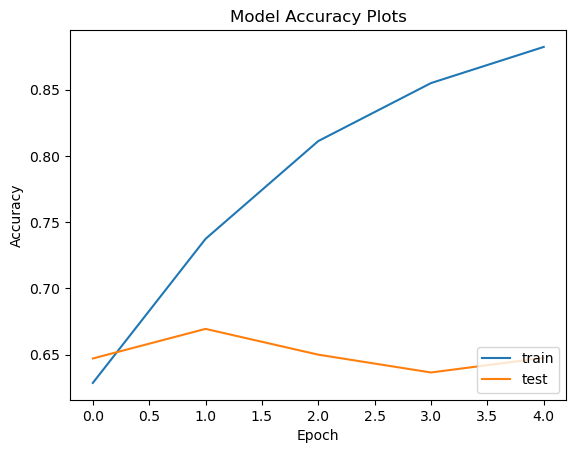

In [38]:
# plot training accuracy from history
plt.plot(h1.history['accuracy'])
# plot validation accuracy from history
plt.plot(h1.history['val_accuracy'])
# add title
plt.title('Model Accuracy Plots')
# define labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### RNN Model - More Parameters

In [39]:
# fit the model for the data
h2 = rnn2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
304/304 [==============================] - 3s 7ms/step - loss: 0.5414 - accuracy: 0.6102 - val_loss: 0.4979 - val_accuracy: 0.6384
Epoch 2/5
304/304 [==============================] - 2s 7ms/step - loss: 0.4526 - accuracy: 0.6774 - val_loss: 0.4707 - val_accuracy: 0.6684
Epoch 3/5
304/304 [==============================] - 2s 6ms/step - loss: 0.3964 - accuracy: 0.7270 - val_loss: 0.4875 - val_accuracy: 0.6612
Epoch 4/5
304/304 [==============================] - 2s 6ms/step - loss: 0.3542 - accuracy: 0.7639 - val_loss: 0.5298 - val_accuracy: 0.6285
Epoch 5/5
304/304 [==============================] - 2s 7ms/step - loss: 0.3213 - accuracy: 0.7973 - val_loss: 0.5421 - val_accuracy: 0.6437


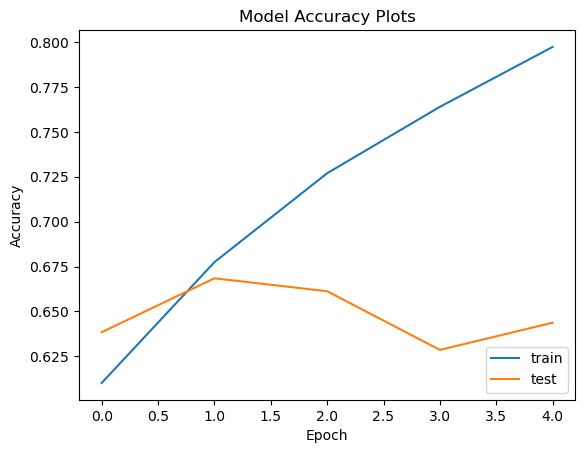

In [40]:
# plot training accuracy from history
plt.plot(h2.history['accuracy'])
# plot validation accuracy from history
plt.plot(h2.history['val_accuracy'])
# add title
plt.title('Model Accuracy Plots')
# define labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### RNN Model - Overfitting Strategies

In [41]:
# fit the model for the data
h3 = rnn3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
304/304 [==============================] - 3s 7ms/step - loss: 0.5388 - accuracy: 0.6121 - val_loss: 0.4810 - val_accuracy: 0.6432
Epoch 2/5
304/304 [==============================] - 2s 6ms/step - loss: 0.4517 - accuracy: 0.6761 - val_loss: 0.4745 - val_accuracy: 0.6593
Epoch 3/5
304/304 [==============================] - 2s 6ms/step - loss: 0.3977 - accuracy: 0.7196 - val_loss: 0.4922 - val_accuracy: 0.6555
Epoch 4/5
304/304 [==============================] - 2s 6ms/step - loss: 0.3548 - accuracy: 0.7632 - val_loss: 0.5277 - val_accuracy: 0.6634
Epoch 5/5
304/304 [==============================] - 2s 6ms/step - loss: 0.3245 - accuracy: 0.7940 - val_loss: 0.5387 - val_accuracy: 0.6509


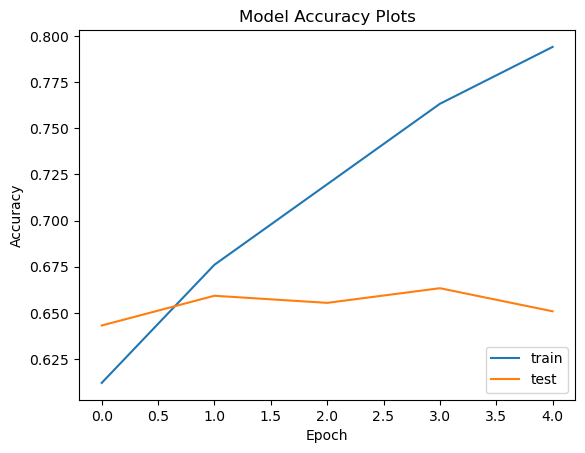

In [42]:
# plot training accuracy from history
plt.plot(h3.history['accuracy'])
# plot validation accuracy from history
plt.plot(h3.history['val_accuracy'])
# add title
plt.title('Model Accuracy Plots')
# define labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### LSTM Model - Fewer Parameters

In [43]:
# fit the model for the data
h4 = lstm1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
304/304 [==============================] - 3s 6ms/step - loss: 0.8237 - accuracy: 0.6464 - val_loss: 0.7464 - val_accuracy: 0.6812
Epoch 2/5
304/304 [==============================] - 2s 6ms/step - loss: 0.6637 - accuracy: 0.7133 - val_loss: 0.7368 - val_accuracy: 0.6764
Epoch 3/5
304/304 [==============================] - 2s 5ms/step - loss: 0.6026 - accuracy: 0.7433 - val_loss: 0.7727 - val_accuracy: 0.6776
Epoch 4/5
304/304 [==============================] - 2s 5ms/step - loss: 0.5616 - accuracy: 0.7607 - val_loss: 0.7905 - val_accuracy: 0.6627
Epoch 5/5
304/304 [==============================] - 2s 5ms/step - loss: 0.5250 - accuracy: 0.7730 - val_loss: 0.8368 - val_accuracy: 0.6742


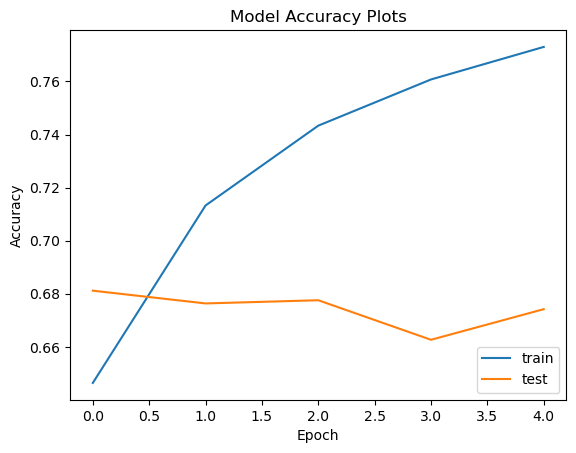

In [44]:
# plot training accuracy from history
plt.plot(h4.history['accuracy'])
# plot validation accuracy from history
plt.plot(h4.history['val_accuracy'])
# add title
plt.title('Model Accuracy Plots')
# define labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### LSTM Model - More Parameters

In [45]:
# fit the model for the data
h5 = lstm2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
304/304 [==============================] - 5s 14ms/step - loss: 0.8112 - accuracy: 0.6485 - val_loss: 0.7497 - val_accuracy: 0.6771
Epoch 2/5
304/304 [==============================] - 4s 13ms/step - loss: 0.6615 - accuracy: 0.7143 - val_loss: 0.7456 - val_accuracy: 0.6783
Epoch 3/5
304/304 [==============================] - 4s 13ms/step - loss: 0.6008 - accuracy: 0.7436 - val_loss: 0.7721 - val_accuracy: 0.6795
Epoch 4/5
304/304 [==============================] - 4s 13ms/step - loss: 0.5502 - accuracy: 0.7663 - val_loss: 0.8159 - val_accuracy: 0.6691
Epoch 5/5
304/304 [==============================] - 4s 13ms/step - loss: 0.5016 - accuracy: 0.7873 - val_loss: 0.8681 - val_accuracy: 0.6648


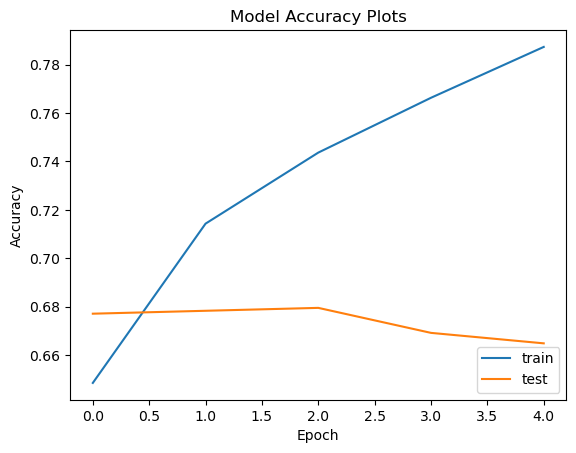

In [46]:
# plot training accuracy from history
plt.plot(h5.history['accuracy'])
# plot validation accuracy from history
plt.plot(h5.history['val_accuracy'])
# add title
plt.title('Model Accuracy Plots')
# define labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### LSTM Model - Over Fitting Strategies

In [47]:
# fit the model for the data
h6 = lstm3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5, batch_size = batch_size, verbose = 1)

Epoch 1/5
304/304 [==============================] - 6s 16ms/step - loss: 0.8275 - accuracy: 0.6400 - val_loss: 0.7522 - val_accuracy: 0.6754
Epoch 2/5
304/304 [==============================] - 5s 16ms/step - loss: 0.6653 - accuracy: 0.7133 - val_loss: 0.7552 - val_accuracy: 0.6672
Epoch 3/5
304/304 [==============================] - 5s 16ms/step - loss: 0.6040 - accuracy: 0.7404 - val_loss: 0.7633 - val_accuracy: 0.6732
Epoch 4/5
304/304 [==============================] - 5s 15ms/step - loss: 0.5607 - accuracy: 0.7614 - val_loss: 0.8084 - val_accuracy: 0.6588
Epoch 5/5
304/304 [==============================] - 5s 15ms/step - loss: 0.5173 - accuracy: 0.7819 - val_loss: 0.8676 - val_accuracy: 0.6571


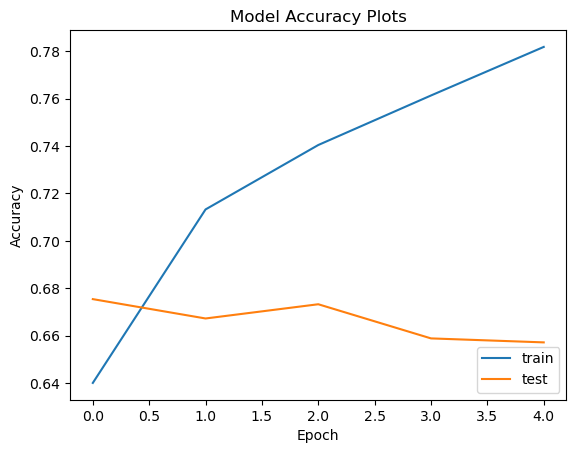

In [48]:
# plot training accuracy from history
plt.plot(h6.history['accuracy'])
# plot validation accuracy from history
plt.plot(h6.history['val_accuracy'])
# add title
plt.title('Model Accuracy Plots')
# define labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [49]:
# evaluate the model on test data
models = [rnn1, rnn2, rnn3, lstm1, lstm2, lstm3]
for model in models:
    _, acc = model.evaluate(X_test, y_test, verbose=2, batch_size = batch_size)
    accs.append(acc)

print(accs)

131/131 - 0s - loss: 0.5950 - accuracy: 0.6475 - 152ms/epoch - 1ms/step
131/131 - 0s - loss: 0.5421 - accuracy: 0.6437 - 191ms/epoch - 1ms/step
131/131 - 0s - loss: 0.5387 - accuracy: 0.6509 - 183ms/epoch - 1ms/step
131/131 - 0s - loss: 0.8368 - accuracy: 0.6742 - 227ms/epoch - 2ms/step
131/131 - 0s - loss: 0.8681 - accuracy: 0.6648 - 479ms/epoch - 4ms/step
131/131 - 0s - loss: 0.8676 - accuracy: 0.6571 - 374ms/epoch - 3ms/step
[0.6696299855838539, 0.6811629024507448, 0.6475252509117126, 0.6436809301376343, 0.650888979434967, 0.6741951107978821, 0.6648246049880981, 0.6571359634399414]


### Sample Test Sentence

In [50]:
# define new test text
test = "A lot of good things are happening. We are respected again throughout the world, and that's a great thing.@realDonaldTrump"

In [51]:
# create dataframe of the test texts using .DataFrame method
test_data = [[test]]
df = pd.DataFrame(test_data, columns = ['text'])

In [52]:
# using regular expression to convert all strings to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())
# using regular expression to preprocess the text by removing everything that is not [a-zA-z0-9\s]
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# tokenize the sentence
tokenizer.fit_on_texts(df['text'].values)
x = tokenizer.texts_to_sequences(df['text'].values)

# pad the sequence to the length of the input sentence padding
x = pad_sequences(x, maxlen = max_len)

In [53]:
# check actual sentiments
print(le_enc.classes_)

['Negative' 'Neutral' 'Positive']


In [56]:
# predict using loaded model
models = [rnn1, rnn2, rnn3, lstm1, lstm2, lstm3]
for model in models:
    pred = model.predict(x)
    # predict class with highest probability using .argmax method
    print(">>> Prediction result for the new text data is: Class ", le_enc.classes_[np.argmax(pred)])

1/1 [==============================] - 0s 14ms/step
>>> Prediction result for the new text data is: Class  Negative
1/1 [==============================] - 0s 13ms/step
>>> Prediction result for the new text data is: Class  Negative
1/1 [==============================] - 0s 13ms/step
>>> Prediction result for the new text data is: Class  Negative
1/1 [==============================] - 0s 16ms/step
>>> Prediction result for the new text data is: Class  Positive
1/1 [==============================] - 0s 23ms/step
>>> Prediction result for the new text data is: Class  Positive
1/1 [==============================] - 0s 14ms/step
>>> Prediction result for the new text data is: Class  Neutral


### Tabular Form

In [55]:
table = []
models = ["Naive Bayes", "Logistic Regression", "RNN - 1", "RNN - 2", "RNN - 3", "LSTM - 1", "LSTM - 2", "LSTM - 3"]

for i in range(len(models)):
    table.append([models[i], accs[i]])
    
print(tabulate(table, headers=["Model", "Accuracy"], tablefmt="fancy_grid"))

╒═════════════════════╤════════════╕
│ Model               │   Accuracy │
╞═════════════════════╪════════════╡
│ Naive Bayes         │   0.66963  │
├─────────────────────┼────────────┤
│ Logistic Regression │   0.681163 │
├─────────────────────┼────────────┤
│ RNN - 1             │   0.647525 │
├─────────────────────┼────────────┤
│ RNN - 2             │   0.643681 │
├─────────────────────┼────────────┤
│ RNN - 3             │   0.650889 │
├─────────────────────┼────────────┤
│ LSTM - 1            │   0.674195 │
├─────────────────────┼────────────┤
│ LSTM - 2            │   0.664825 │
├─────────────────────┼────────────┤
│ LSTM - 3            │   0.657136 │
╘═════════════════════╧════════════╛
